#                                       Portfolio Optimization & Monte Carlo Simulation

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
%matplotlib inline
import yfinance as yf

## Create and Analyse Your Desired Portfolio

#### Enter list of stocks

In [158]:
user_portfolio = []
imput_tickers = input("Enter ticker symbols separated by a comma:") or ("MSFT,AAPL,AMZN,GOOGL,V")
user_portfolio.extend(map(str, imput_tickers.split(",")))
print(user_portfolio)
type(user_portfolio)

Enter ticker symbols separated by a comma: 


['MSFT', 'AAPL', 'AMZN', 'GOOGL', 'V']


list

#### Enter desired weight distribution for selected stocks

In [161]:
p_weights = []
imput_weight = input() or ('0.2,0.2,0.2,0.2,0.2')
p_weights.extend(map(float, imput_weight.split(",")))
print(p_weights)
print(f'Sum of weights=:{sum(p_weights)}')

[0.2, 0.2, 0.2, 0.2, 0.2]
Sum of weights=:1.0


#### Select desired benchmark to simulate results

In [163]:
imput_bm = input("Enter benchmark symbol:") or ("SPY")
benchmark = imput_bm.split(',')
print(benchmark)
type(benchmark)

Enter benchmark symbol: 


['SPY']


list

#### Define number of simulations & number of periods per simulation

In [185]:
number_simulations = 500
number_records =252*8 #252 trading days * no of years

## Import Data

In [165]:
# Datasource Yahoo Finance

list_of_tickers=benchmark+user_portfolio

data = yf.download(
        tickers = list_of_tickers,
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        period = "30y",
        interval = "1d",
        group_by = 'ticker',
        # adjust all OHLC automatically, adjusted for stock splits
        auto_adjust = True,
        prepost = True,
        threads = True,
        proxy = None
    )
data.tail()

[*********************100%***********************]  6 of 6 completed


V                                                  \
                  Open        High         Low       Close      Volume   
Date                                                                     
2020-05-11  183.562638  184.311384  181.126714  183.253159   8680400.0   
2020-05-12  183.253158  183.682447  179.070159  179.169998   8219700.0   
2020-05-13  178.500000  181.089996  175.039993  177.089996  13377100.0   
2020-05-14  175.940002  181.050003  173.820007  180.899994   9693900.0   
2020-05-15  179.979996  184.139999  178.869995  183.490005  10778662.0   

                   AMZN                                                    \
                   Open         High          Low        Close     Volume   
Date                                                                        
2020-05-11  2374.699951  2419.669922  2372.110107  2409.000000  3253700.0   
2020-05-12  2411.850098  2419.000000  2355.000000  2356.949951  3074900.0   
2020-05-13  2366.800049  2407.699951  2337.800049  2367.919922  4782900.0   
2020-05-14  2361.010010  2391.370117  2353.209961  2388.850098  3640700.0   
2020-05-15  2368.520020  2411.000000  2356.375000  2409.780029  4066463.0   

            ...        MSFT                                                \
            ...        Open        High         Low       Close    Volume   
Date        ...                                                             
2020-05-11  ...  183.149994  187.509995  182.850006  186.740005  30809400   
2020-05-12  ...  186.800003  187.039993  182.300003  182.509995  32038200   
2020-05-13  ...  182.550003  184.050003  176.539993  179.750000  44711500   
2020-05-14  ...  177.539993  180.690002  175.679993  180.529999  41818400   
2020-05-15  ...  179.059998  183.460007  177.000000  183.160004  37376952   

                  AAPL                                                
                  Open        High         Low       Close    Volume  
Date                                                                  
2020-05-11  308.100006  317.049988  307.239990  315.010010  36405900  
2020-05-12  317.829987  319.690002  310.910004  311.410004  40575300  
2020-05-13  312.149994  315.950012  303.209991  307.649994  50155600  
2020-05-14  304.510010  309.790009  301.529999  309.540009  39648100  
2020-05-15  300.350006  307.899994  300.420013  307.709991  40697141  

[5 rows x 30 columns]

## Data cleanup

In [167]:
# Historic adjusted close prices
df_yf = data.sort_index()
df_yf.drop(columns=['Open', 'High', 'Low', 'Volume'], level=1, inplace=True)
df_yf = df_yf.droplevel(axis=1, level=1)
df_yf.index = df_yf.index.date
df_yf.dropna(inplace=True)
df_yf.hvplot(title ="Historic Stocks & Benchmark Performance")

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [168]:
# Isolate cleaned data
user_portfolio_df=df_yf.drop([benchmark[0]], axis =1)
bm_portfolio_df=df_yf[benchmark[0]]

# Calculate daily returns
user_portfolio_returns = user_portfolio_df.pct_change().dropna()
bm_portfolio_returns = bm_portfolio_df.pct_change().dropna()

In [181]:
bm_portfolio_returns.hvplot(title ="Benchmark historic returns")

:Curve   [index]   (SPY)

In [180]:
user_portfolio_returns.hvplot(title ="Stocks historic returns")

:NdOverlay   [Variable]
   :Curve   [index]   (value)

## Define variables for Benchmark Monte Carlo simulation

In [170]:
bm_portfolio_ret_mean = bm_portfolio_returns.mean()
bm_portfolio_ret_std = bm_portfolio_returns.std()
bm_last_price = bm_portfolio_df[-1]

#TODO provide clear message to user, round to two decimal points
#we might want to illustrate what standard deviation means
print(f'Your portfolio average historical returns for the BM is:{bm_portfolio_ret_mean}')
print(f'Your portfolio standard deviation for the BM is:{bm_portfolio_ret_std}')
print(f'The present value of your benchmark is:{bm_last_price}')

Your portfolio average historical returns for the BM is:0.00042723164445259353
Your portfolio standard deviation for the BM is:0.013228802500195777
The present value of your benchmark is:286.2799987792969


### Run BM Monte Carlo Simulation

In [268]:
simulated_price_df = pd.DataFrame()
bm_montecarlo_returns = pd.DataFrame()

for n in range(number_simulations):
    simulated_benchmark_prices = [bm_last_price]
    for i in range(number_records):
        simulated_benchmark_price = simulated_benchmark_prices[-1] * (1 + np.random.normal(bm_portfolio_ret_mean, bm_portfolio_ret_std))
        simulated_benchmark_prices.append(simulated_benchmark_price)
    simulated_price_df["SPY prices"] = pd.Series(simulated_benchmark_prices)
    simulated_daily_returns_bm = simulated_price_df.pct_change()
    b_weights = [1.00] 
    portfolio_daily_returns = simulated_daily_returns_bm.dot(b_weights)
    bm_montecarlo_returns[f'T{n}'] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
bm_montecarlo_returns.head()

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T490,T491,T492,T493,T494,T495,T496,T497,T498,T499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991826,1.004136,0.988368,0.991939,1.010095,0.996162,1.004588,1.007628,1.013409,0.997953,...,0.996934,1.003438,0.998260,1.006233,1.017171,0.992794,0.977405,0.997816,1.012147,0.993240
2,0.984170,1.016757,0.985450,0.986588,1.017999,0.989668,1.005269,1.020949,1.001529,0.983952,...,0.995337,1.013529,0.996632,0.991918,1.042859,1.011528,0.958157,1.005637,1.022004,0.991014
3,0.974662,1.025841,0.986403,0.987055,1.021390,0.992008,1.008618,1.021114,0.998966,0.979479,...,1.010193,1.030292,0.979771,0.980086,1.049676,1.004507,0.954095,1.015452,1.036040,0.980809
4,0.974636,1.024937,0.977494,0.986723,1.016171,0.995357,0.994852,1.015448,1.002097,0.960262,...,1.016062,1.023691,0.975746,0.987276,1.059540,1.020813,0.957942,1.020749,1.058372,0.990064


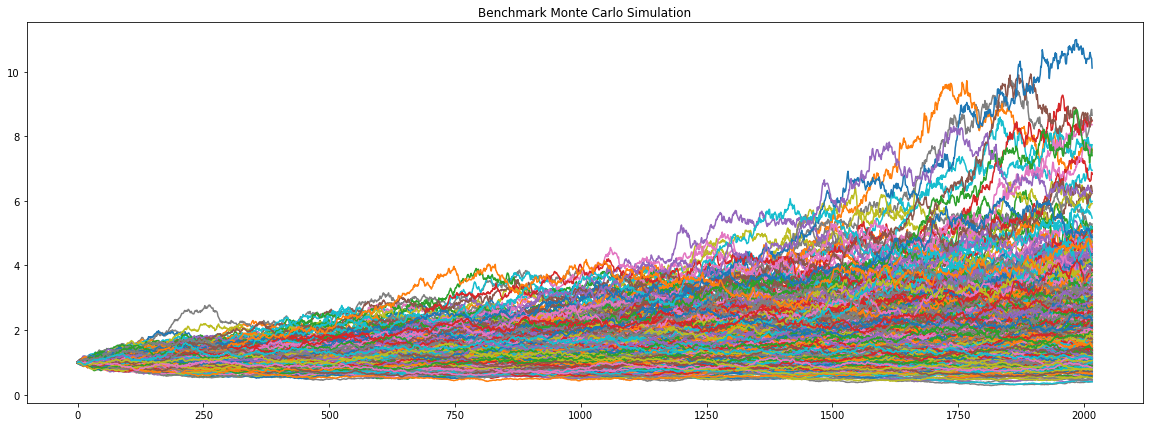

In [264]:
def get_bm_mc_chart():
    bm_mc_chart = bm_montecarlo_returns.plot(
        title="Benchmark Monte Carlo Simulation",
        legend=None, 
        figsize=(20,7)
    )
    return bm_mc_chart
get_bm_mc_chart();

## Define variables for portfolio Monte Carlo simulation

In [208]:
pf_means = {}
pf_std = {}
pf_last_day = {}

for stock in user_portfolio:
    pf_means[stock] = user_portfolio_returns.mean()[stock]
    pf_std[stock] = user_portfolio_returns.std()[stock]
    pf_last_day[stock] = user_portfolio_df[stock][-1]
pd.DataFrame([pf_means,pf_std,pf_last_day])

,MSFT,AAPL,AMZN,GOOGL,V
0,0.000862,0.001160,0.001428,0.000773,0.001102
1,0.018117,0.019700,0.023458,0.018475,0.019369
2,183.160004,307.709991,2409.780029,1373.060059,183.490005


### Run portfolio Monte Carlo Simulation

In [269]:
pf_montecarlo_returns = pd.DataFrame()

for n in range(number_simulations):
    simulated_portfolio_prices = {stock:[pf_last_day[stock]] for stock in user_portfolio}
    for i in range(number_records):
        for stock in user_portfolio:
            simulated_stocks_price = simulated_portfolio_prices[stock][-1] * (1 + np.random.normal(pf_means[stock], pf_std[stock]))
            simulated_portfolio_prices[stock].append(simulated_stocks_price)
    simulated_prices_df = pd.DataFrame(simulated_portfolio_prices)
    simulated_daily_returns = simulated_prices_df.pct_change()
    simulated_daily_returns.dropna(inplace=True)
    portfolio_daily_returns = simulated_daily_returns.dot(p_weights)
    pf_montecarlo_returns[f'T{n}'] = (1+portfolio_daily_returns.fillna(0)).cumprod()
pf_montecarlo_returns.head()

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T490,T491,T492,T493,T494,T495,T496,T497,T498,T499
1,1.016274,0.993546,1.004455,1.002111,1.008395,0.997730,1.007753,0.985908,1.002226,0.998637,...,0.996426,0.988285,0.993369,1.019364,1.023723,0.997049,1.000001,0.993974,0.997530,1.008036
2,1.021708,0.981099,1.001602,0.993780,1.025839,0.995293,1.007041,0.976076,1.002186,1.009382,...,1.003686,1.001087,1.001869,1.003425,1.034915,1.010347,0.992515,1.000829,0.995819,0.985126
3,1.019432,0.993580,1.005526,0.989331,1.030690,0.980000,1.015662,0.990671,1.020115,1.013650,...,0.997221,1.003063,0.985381,1.000856,1.036055,0.999897,0.995958,0.999295,0.995160,0.996049
4,1.019296,0.996042,1.007063,0.983342,1.015694,0.981117,1.007677,1.001133,1.028020,1.008886,...,0.986934,1.006028,0.992888,1.000395,1.039905,0.994108,0.993879,1.004868,0.990053,0.998871
5,1.024302,0.988819,1.011624,0.989057,1.012311,0.990384,1.001160,0.995231,1.027539,1.021423,...,1.003106,0.998703,1.017350,1.005192,1.034592,1.011831,1.011898,0.992769,0.986628,1.001551


In [273]:
def get_pf_mc_chart():
    pf_mc_chart = pf_montecarlo_returns.plot(
        title="Portfolio Monte Carlo Simulation",
        legend=None, 
        figsize=(20,7)
    )
    return pf_mc_chart

## Benchmark & Portfolio Comparison

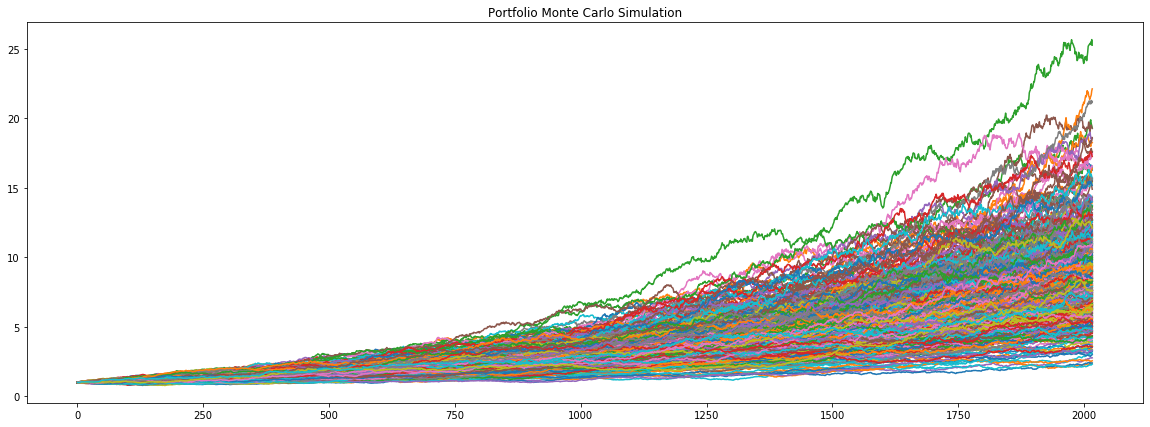

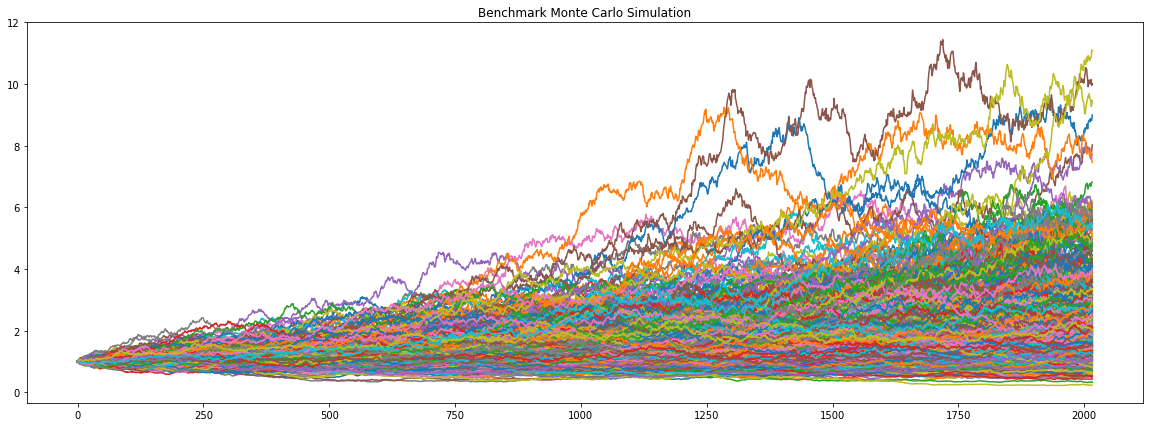

In [274]:
geo_column = pn.Column("### Benchmark & Portfolio Comparison", get_pf_mc_chart(), get_bm_mc_chart())
geo_column;

## Probability Distribution of simulated returns with 90% (Green) 95% (Red) Confidence Intervals

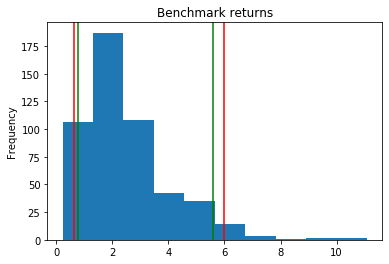

In [280]:
pf_cumulative_ret=pf_montecarlo_returns.iloc[-1, :]
bm_cumulative_ret=bm_montecarlo_returns.iloc[-1, :]
pf_confidence_interval = pf_cumulative_ret.quantile(q=[0.025, 0.975])
bm_confidence_interval = bm_cumulative_ret.quantile(q=[0.025, 0.975])
pf_confidence_interval_2 = pf_cumulative_ret.quantile(q=[0.05, 0.95])
bm_confidence_interval_2 = bm_cumulative_ret.quantile(q=[0.05, 0.95])

def get_pf_hist_chart():
    pf_hist = pf_cumulative_ret.plot(
        kind='hist', 
        bins=10, 
        title="Portofolio returns"
    ) 
    plt.axvline(pf_confidence_interval.iloc[0], color='r')
    plt.axvline(pf_confidence_interval.iloc[1], color='r')
    plt.axvline(pf_confidence_interval_2.iloc[0], color='g')
    plt.axvline(pf_confidence_interval_2.iloc[1], color='g')
    return pf_hist

def get_bm_hist_chart():
    bh_hist = bm_cumulative_ret.plot(
        kind='hist',
        bins=10,
        title="Benchmark returns"
    )
    plt.axvline(bm_confidence_interval.iloc[0], color='r')
    plt.axvline(bm_confidence_interval.iloc[1], color='r')
    plt.axvline(bm_confidence_interval_2.iloc[0], color='g')
    plt.axvline(bm_confidence_interval_2.iloc[1], color='g')
    return bh_hist

get_bm_hist_chart();

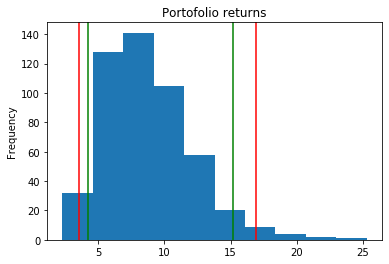

In [281]:
get_pf_hist_chart();

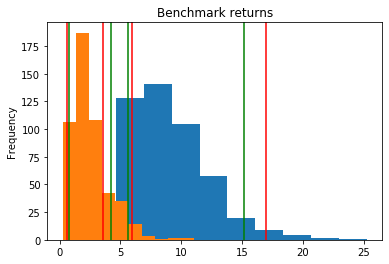

In [283]:
geo_column = pn.Column("### Benchmark & Portfolio Comparison", get_pf_hist_chart(), get_bm_hist_chart())
geo_column;